In [1]:
import tensorflow as tf 
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Reshape, Lambda
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import image
import tensorflow.keras.callbacks
import cv2
from PIL import Image
import numpy as np
import pandas as pd

/Users/mattevanoff/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/mattevanoff/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mattevanoff/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data_path = '../../data/raw/word_level'
meta_data_path = '../../data/preprocessed/meta.csv'
meta_json_data_path = '../../data/preprocessed/meta_json.csv'

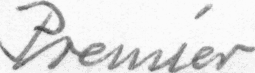

In [3]:
sample_image_path = os.path.join(data_path, 'a01', 'a01-007', 'a01-007-08-05.png')
Image.open(sample_image_path)

In [4]:
meta = pd.read_json(meta_json_data_path)
meta.sort_index().head()

,filename,meta,ids,pos_tag,folder,document
0,d05-040,"[Or, when, he, found, cock-fighting, going, on...","[d05-040-00-00, d05-040-00-01, d05-040-00-02, ...","[CC, WRB, PP3A, VBD, NN, VBG, RP, IN, NN, ?, N...",d05,d05-040
1,p03-151,"["", Isn't, it, ?, "", he, rose, and, smoothed, ...","[p03-151-00-00, p03-151-00-01, p03-151-00-02, ...","[*', BEZX, PP3, ?, **', PP3A, VBD, CC, VBD, PP...",p03,p03-151
2,n02-016,"["", Oh, ,, she, was, due, !, "", And, then, he,...","[n02-016-00-00, n02-016-00-01, n02-016-00-02, ...","[*', UH, ,, PP3A, BEDZ, JJ, !, **', CC, RN, PP...",n02,n02-016
3,h07-030,"[Some, development, corporations, have, sought...","[h07-030-00-00, h07-030-00-01, h07-030-00-02, ...","[DTI, NN, NNS, HV, VBN, TO, VB, JJ, NNS, IN, J...",h07,h07-030
4,l04-093,"[He, lifted, out, the, heavy, bundles, of, not...","[l04-093-00-00, l04-093-00-01, l04-093-00-02, ...","[PP3A, VBD, RP, ATI, JJ, NNS, INO, NNS, CC, VB...",l04,l04-093


In [5]:
# remove weird outlier 
meta.drop(index=494, axis=1, inplace=True)

# CHECK remove longer words???? Threshold at 15? 

In [6]:
from visuals import check_x_y
check_x_y(meta, 101, data_path)

['Behind', "Bonn's", 'slogan', 'of', 'German', 'self-', 'determination', 'is', 'the', 'intention', 'to', 'impose', 'on', 'East', 'Germany', 'the', 'regime', 'existing', 'in', 'West', 'Germany', '.', 'REFUGEES', 'are', 'pouring', 'out', '#', 'of', 'East', 'Germany', 'into', 'West', 'Berlin', 'faster', 'than', 'ever', '.', 'Mr.', "K's", 'latest', 'speech', 'scared', '1,157', 'East', 'Germans', 'to', 'cross', 'into', 'West', "Berlin's", 'reception', 'centre', 'DURING', 'MONDAY', 'NIGHT', '.', 'And', 'officials', 'expect', 'the', 'total', 'to', 'leap', 'to', '3,000', 'a', 'day', '.']
68 68


In [6]:
unique = meta.drop_duplicates(subset=['document'], keep='last')

from collections import Counter

all_tokens = Counter()
all_lower_tokens = Counter()
all_chars = Counter()
all_lower_chars = Counter()
i = 1
for tokens in unique.meta:
    i += 2
    for token in tokens:
        all_tokens[token] += 1
        all_lower_tokens[token.lower()] += 1
        for char in token:
            all_chars[char] += 1
            all_lower_chars[char.lower()] += 1

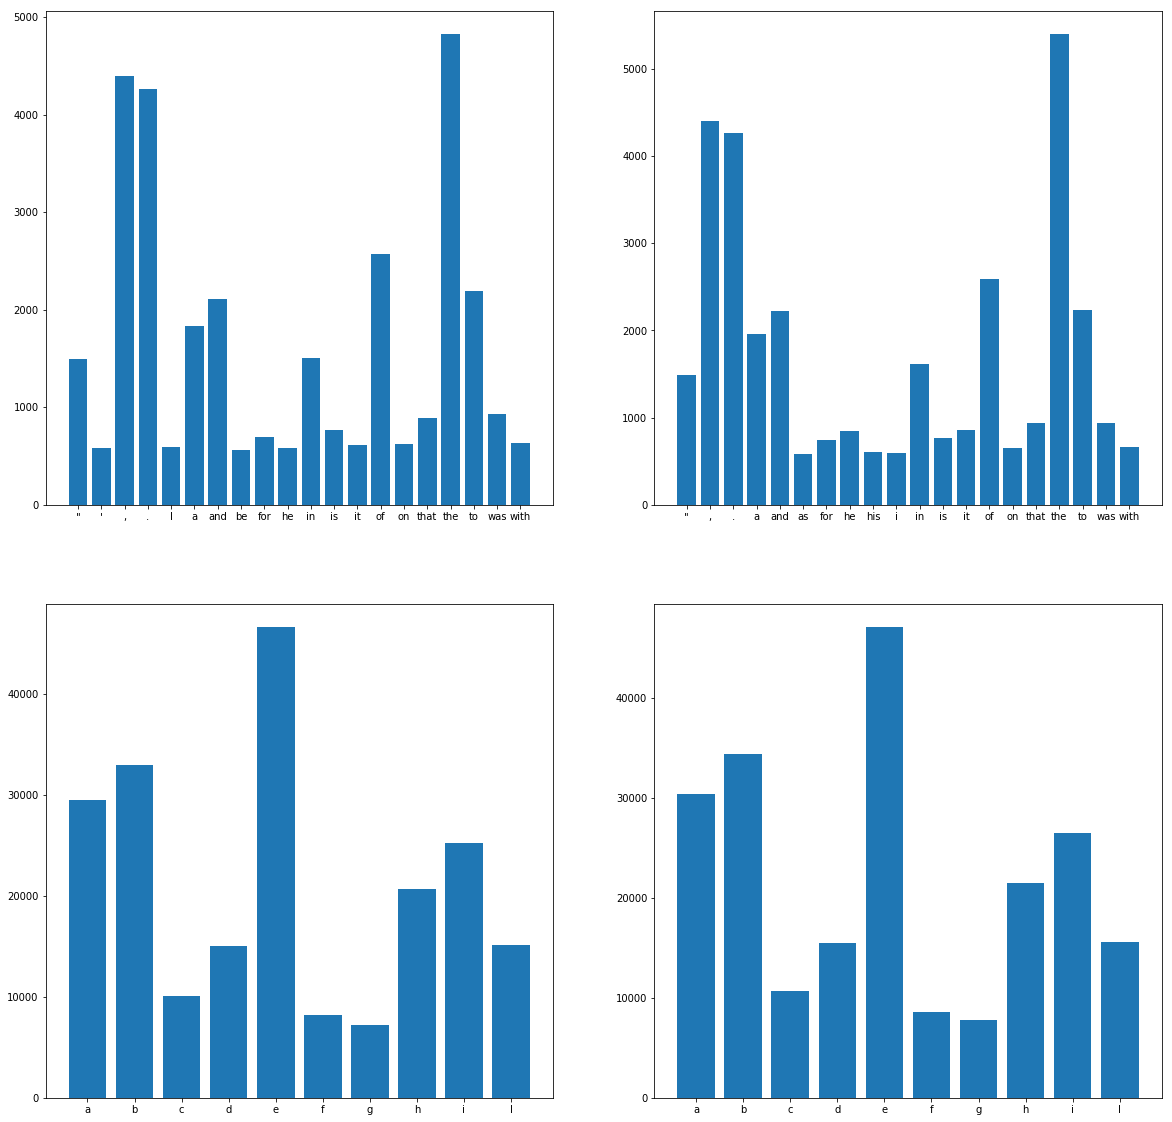

In [7]:
from visuals import plot_most_common
plt.figure(figsize=(20, 20))
for i, col in enumerate([all_tokens, all_lower_tokens, all_chars, all_lower_chars]):
    plt.subplot(2, 2, i+1)
    plot_most_common(col)

# Model

In [8]:
letters = set(all_chars.keys())

21

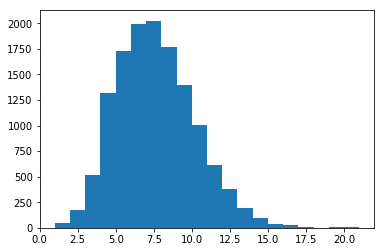

In [9]:
word_lengths = [len(x) for x in list(all_tokens.keys())]

max_text_len = max(word_lengths)
plt.hist(word_lengths, bins=20)
max_text_len

# Data And Processing 

In [27]:
sess = tf.Session()
K.set_session(sess)

from collections import defaultdict
from tqdm import tqdm_notebook
import pdb
import dill as pickle

def duplicate_row(df, col_name):
    """When cell contents are lists, create a row for each element in the list"""
    series = df.apply(lambda x: pd.Series(x[col_name]),axis=1).stack().reset_index(level=1, drop=True)
    series.name = col_name
    return series
    
def create_word_level_df(df, cols=[]):
    """Combine multiple Series into a pandas DataFrame"""
    meta_series = duplicate_row(df, 'meta')
    id_series = duplicate_row(df, 'ids')
    pos_series = duplicate_row(df, 'pos_tag')
    df = df.drop(['meta', 'ids', 'pos_tag'], axis=1).join(pd.concat([meta_series, id_series, pos_series], axis=1))
    return df.rename(columns={'meta': 'token', 'ids': 'image_name'}).reset_index()

def absoluteFilePaths(directory):
    """Walk filepaths"""
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.join(dirpath, f)

def create_image_path(df, data_path):
    """Create dictionary for mapping of word to data path"""
    all_paths = [i for i in absoluteFilePaths(data_path)]
    all_path_endings = [i.split('/')[-1].split('.')[0] for i in all_paths]
    all_path_dict = defaultdict(lambda: 0, dict(zip(all_path_endings, all_paths)))
    df['image_path'] = df['image_name'].map(lambda x: all_path_dict[x])
    return df

def unpickle(filename):
    """Unpickle file"""
    with open(filename, 'rb') as f:
        return pickle.load(f)

# def labels_to_text(labels, letters):
#     return ''.join(list(map(lambda x: letters[int(x)], labels)))

# def text_to_labels(text, letters):
#     return list(map(lambda x: letters.index(x), text))


class TextImageGenerator:
    
    def __init__(self, meta, letters, data_path, img_width, img_height, batch_size, downsample_factor, 
                 max_text_len=21, pre_pad=True, save_letters=True):
        
        self.letters = letters
        # create letters mapping 
        # +2 0 for pad value and 1 for OOV
        self.letter2idx = defaultdict(lambda: 1, {x: i+2 for i, x in enumerate(sorted(letters))})
        self.letter2idx['<unk>'] = 1
        self.letter2idx['<pad>'] = 0
        self.pad_idx = self.letter2idx['<pad>']
        self.idx2letter = {v: k for k, v in self.letter2idx.items()}
        
        if save_letters:
            with open(os.path.join('../../data/', 'processed', 'letters_map.pkl'), 'wb') as f:
                pickle.dump(self.letter2idx, f)
            
        self.data_path = data_path
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.max_text_len = max_text_len
        self.pre_pad = pre_pad
        
        # TODO: should I create DF as well? 
        self.word_level_df = create_word_level_df(meta)
        self.word_level_df = create_image_path(self.word_level_df, data_path)
   
        # training data 
        self.samples = self.word_level_df[['image_path', 'token']].values.tolist()
        self.N = len(self.samples)
        self.current_index = 0
        
    def build_data(self):
        self.images = np.zeros((self.N, self.img_height, self.img_width))
        self.texts = []
        bad_records = []
        for i, (img_path, text) in enumerate(self.samples):
            try:
                # read image 
                img = cv2.imread(img_path)
                # grayscale image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # resize image
                img = cv2.resize(img, (self.img_width, self.img_height))
                # change image type
                img = img.astype(np.float32)
                # scale image 
                img /= 255
                # width and height are backwards from typical Keras convention
                # because width is the time dimension when it gets fed into the RNN
                self.images[i, :, :] = img
                self.texts.append(text)
            except:
                print('Image not available for image', i, img_path, text)
                bad_records.append(i)
        # update stats to remove bad records with no image data 
        self.N -= len(bad_records)
        self.indexes = list(range(self.N))
        self.images = np.delete(self.images, bad_records, axis=0)

    def get_output_size(self):
        return len(self.letters) + 1

    def next_sample(self):
        self.current_index += 1
        if self.current_index >= self.N:
            self.current_index = 0
            random.shuffle(self.indexes)
        return self.images[self.indexes[self.current_index]], self.texts[self.indexes[self.current_index]]

    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X = np.ones([self.batch_size, 1, self.img_width, self.img_height])
            else:
                X = np.ones([self.batch_size, self.img_width, self.img_height, 1])

            y = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_width // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X[i] = img
#                 pdb.set_trace()
#                 y_numeric = text_to_labels(text, self.letters)
                y_numeric = [self.letter2idx[l] for l in text]
                if self.pre_pad: padded_y = ([self.pad_idx] * (self.max_text_len - len(y_numeric))) + y_numeric
                else: padded_y = y_numeric + ([self.pad_idx] * (self.max_text_len - len(y_numeric)))
                y[i] = padded_y
#                 y[i] = text_to_labels(text, self.letters)
                source_str.append(text)
                label_length[i] = len(text)

            inputs = {
                'X': X,
                'y': y,
                'X_length': input_length,
                # TODO might need to update label length to self.max_text_len
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

        
        

In [11]:
# test run
# letters_concat = ''.join(letters)
# tiger = TextImageGenerator(meta, letters_concat, data_path, 
#                            img_width=128, img_height=64, batch_size=1, downsample_factor=4)
# tiger.build_data()

# for inp, out in tiger.next_batch():
#     print(inp, out)
#     break

Image not available for image 45861 ../../data/raw/word_level/r06/r06-022/r06-022-03-05.png more
Image not available for image 74261 ../../data/raw/word_level/a01/a01-117/a01-117-05-02.png Powell


Text generator output (data which will be fed into the neutral network):
1) the_input (image)


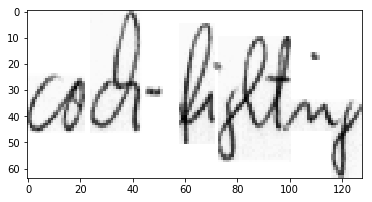

2) the_labels (plate number): <pad><pad><pad><pad><pad><pad><pad><pad>cock-fighting is encoded as [ 0.  0.  0.  0.  0.  0.  0.  0. 57. 69. 57. 65. 13. 60. 63. 61. 62. 74.
 63. 68. 61.]
3) input_length (width of image that is fed to the loss function): 30 == 128 / 4 - 2
4) label_length (length of plate number): 13


In [17]:
for inp, out in tiger.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    print('1) the_input (image)')
    img = inp['X'][0, :, :, 0]
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): {} is encoded as {}'.format( 
           ''.join([tiger.idx2letter[int(x)] for x in inp['y'][0]]), inp['y'][0])) 
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], tiger.img_width))
    
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    break

### TODO 

- SPLIT DATA INTO TRAIN / TEST FOLDERS 

In [12]:
letters_concat = ''.join(letters)
tiger = TextImageGenerator(meta, letters_concat, data_path, image_width, image_height, batch_size, 
                               downsample_factor, max_text_len, save_letters=False)
tiger.build_data()

Image not available for image 45861 ../../data/raw/word_level/r06/r06-022/r06-022-03-05.png more
Image not available for image 74261 ../../data/raw/word_level/a01/a01-117/a01-117-05-02.png Powell


In [25]:
from tensorflow.keras.layers import Bidirectional, CuDNNGRU
tf.reset_default_graph()

CTC_SKIP_FIRST = 2
image_width = 128 
image_height = 64
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
batch_size = 32
downsample_factor = pool_size ** 2
max_text_len = 21
activation = 'relu'
learning_rate = 0.02
epochs = 1

def ctc_loss_function(args):
    y_pred, y_true, X_length, y_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, CTC_SKIP_FIRST:, :]
    return K.ctc_batch_cost(y_true, y_pred, X_length, y_length)



def conv_block(X, conv_filters, kernel_size, strides=(1, 1), activation='relu', pool_size=2, name='layer'):
    X = Conv2D(conv_filters, kernel_size, strides=strides, padding='same', activation=activation, 
               kernel_initializer='he_normal', name='conv_'+str(name))(X)
    X = MaxPooling2D(pool_size=(pool_size, pool_size), name='max_'+str(name))(X)
    return X


def get_model(meta, out_dir, load=False, sample_run=False):
    input_shape = (image_width, image_height, 1)
    letters_concat = ''.join(letters)
    # get data
#     if sample_run:
#         meta = meta.sample(sample_run) 
    tiger = TextImageGenerator(meta, letters_concat, data_path, image_width, image_height, batch_size, 
                               downsample_factor, max_text_len, save_letters=False)   
    # build keras data
    tiger.build_data()
    
    # CNN model -- feature extractor
    # input 
    input_ = Input(shape=(image_width, image_height, 1), name='X') # [W * D * 1]
    # conv layer 1
    X = conv_block(input_, conv_filters, kernel_size, activation=activation, pool_size=pool_size, name='layer1')
    # conv layer 2
    X = conv_block(X, conv_filters, kernel_size, activation=activation, pool_size=pool_size, name='layer2')
    # reshape to input to RNN
    X_shape = (image_width // (pool_size ** 2), (image_height // (pool_size ** 2)) * conv_filters)
    X = Reshape(X_shape)(X)
    
    # cuts down input size going into RNN:
    X = Dense(time_dense_size, activation=activation, name='dense1')(X)
    
    # RNN model -- Bidirectional GRU since language is ambiguous
    # return_sequences returns the hidden state output for each input time step.
    X = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True, kernel_initializer='he_normal'), name='gru1')(X)
    X = Bidirectional(CuDNNGRU(rnn_size, return_sequences=True, kernel_initializer='he_normal'), name='gru2')(X)
    
    
    y_pred = Activation('softmax', name='softmax')(X)
    Model(inputs=input_, outputs=y_pred).summary()
    
    labels = Input(name='y', shape=[tiger.max_text_len], dtype='float32')
    input_length = Input(name='X_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_loss_function, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    model = Model(inputs=[input_, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_], [y_pred])

    model.fit_generator(generator=tiger.next_batch(), 
                        steps_per_epoch=tiger.N,
                        epochs=1, )
    return model

    
    
#     # Output activations 
#     X = Dense(tiger.get_output_size(), activation='softmax', kernel_initializer='he_normal', name='dense2')(X)
# #     X = Dense(tiger.get_output_size(), kernel_initializer='he_normal', name='dense2')(X)
# #     logits = Activation('softmax', name='output')(X)
    
#     print(Model(input_, X).summary())
    
#     # Other inputs for model 
#     X_length = Input(shape=[1], dtype=np.int64, name='X_length')
#     label_ = Input(shape=[tiger.max_text_len], dtype=np.float32, name='y')
#     label_length = Input(shape=[1], dtype=np.int64, name='label_length')
    
#     # CTC loss 
#     loss = Lambda(ctc_loss_function, output_shape=(1, ), name='ctc')([X, label_, X_length, label_length])
    
#     optimizer = tensorflow.keras.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
# #     optimizer = tensorflow.keras.optimizers.Adam(lr=learning_rate)

#     if load:
#         model = load_model(out_dir + 'model.h5', compile=False)
#     else:
#         model = Model([input_, label_, X_length, label_length], loss)
        
#     # compile model -- the loss calc occurs elsewhere, so use a dummy lambda func for the loss
#     model.compile(loss={'ctc': lambda y_true, y_pred: X}, optimizer=optimizer)
    
#     if not load:
#         # captures output of softmax so we can decode the output during visualization
#         test_func = K.function([input_], [X])
#         # fit model 
#         model.fit_generator(generator=tiger.next_batch(), steps_per_epoch=tiger.N, epochs=epochs) 
#     # return text class, model 
#     return tiger, model

In [26]:
import shutil
model_outdir = 'models/'
if not os.path.exists(model_outdir):
    os.makedirs(model_outdir)
    
# shutil.rmtree(model_outdir)
model = get_model(meta, model_outdir)

Image not available for image 45861 ../../data/raw/word_level/r06/r06-022/r06-022-03-05.png more
Image not available for image 74261 ../../data/raw/word_level/a01/a01-117/a01-117-05-02.png Powell
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 128, 64, 1)        0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 128, 64, 16)       160       
_________________________________________________________________
max_layer1 (MaxPooling2D)    (None, 64, 32, 16)        0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 64, 32, 16)        2320      
_________________________________________________________________
max_layer2 (MaxPooling2D)    (None, 32, 16, 16)        0         
_________________________________________________________________
reshape (Res

NotFoundError: FeedInputs: unable to find feed output X:0

In [18]:
# Save model 
if not os.path.exists(model_outdir):
    os.makedirs(model_outdir)
model.save(model_outdir + 'model.h5')

In [ ]:
model_outdir = 'models/'
model = get_model(model_outdir, load=True)

Image not available for image 45861 ../../data/raw/word_level/r06/r06-022/r06-022-03-05.png more
Image not available for image 74261 ../../data/raw/word_level/a01/a01-117/a01-117-05-02.png Powell
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 128, 64, 1)        0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 128, 64, 16)       160       
_________________________________________________________________
max_layer1 (MaxPooling2D)    (None, 64, 32, 16)        0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 64, 32, 16)        2320      
_________________________________________________________________
max_layer2 (MaxPooling2D)    (None, 32, 16, 16)        0         
_________________________________________________________________
reshape (Res

In [18]:
# TODO this should be beam search with a dictionary and language model
def decode_batch(out):
    output = []
    for i in range(out.shape[0]):
        pred = np.argmax(out[i, 2:], 1)
        pred = [k for k, g in itertools.groupby(pred)]
        out_str = ''
        for c in pred:
            if c < len(tiger.letters):
                out_str += tiger.letters[c]
        output.append(out_str)
    return output

In [16]:
tiger.letter2idx['F']

34

In [ ]:
letters_concat = ''.join(letters)
tiger_test = TextImageGenerator(meta.sample(100), letters_concat, data_path, image_width, image_height, batch_size, 
                               downsample_factor, max_text_len, save_letters=False)
tiger_test.build_data()

model_input = model.get_layer('X').input
model_output = model.get_layer('output').output

for inp_value, _ in tiger_test.next_batch():
    batch_X, batch_y = inp_value['X'], inp_value['y']
    bz_size = batch_X.shape[0]
    model_output = sess.run(model_output, feed_dict={model_input: batch_X})
    pred_texts = decode_batch(model_output)
    texts = []
    
    
    
